In [1]:
from numpy import *
import matplotlib.pyplot as plt
from LRFutils import progress
from LRFutils import archive
import animation
from numba import njit

---

# Config

In [2]:
L = 10 # Size of the grid
D1 = 1e4 # Diffusion coefficient [s-1]
F = 1e4 # linspace(5e-6,1e4,1000,endpoint=True) # Flux [s-1]

# Starting monomers
N = 0 # L**2 / 100

steps = 300

---

# Class definition

In [3]:
class Layer:
    def __init__(self, L):
        self.grid = []
        for i in range(L):
            self.grid.append([])
            for j in range(L):
                self.grid[i].append([])
        self.islands = []
    
    def elements(self):
        monomers = []
        islands = []
        for row in self.grid:
            for monomerList in row:
                if monomerList != []:
                    # If the monomer is NOT a part of an islan, it is counted as a monomer
                    if monomerList[0].island is None:
                        monomers += monomerList
    
                    # If the monomer is a part of an islan, it is counted as an island
                    else:
                        if monomerList[0].island not in islands:
                            islands.append(monomerList[0].island)
        return monomers, islands

    def monomers(self):
        return self.elements()[0]

    def islands(self):
        return self.elements()[1]

    def heightmap(self):
        heightmap = zeros((L,L))
        for x in range(L):
            for y in range(L):
                if self.grid[x][y] != []:
                    heightmap[x][y] = len(self.grid[x][y])
        return heightmap

    def corrected_pos(x):
        if x < 0:
            return L-1
        elif x >= L:
            return 0
        else:
            return x

In [4]:
class Island:
    all = []
    def __init__(self, layer, monomers):
        Island.all.append(self)
        self.layer = layer
        if type(monomers) is not list: monomers = [monomers] 
        self.monomers = monomers
    
    def add_monomer(self, monomer):
        monomer.island = self
        self.monomers.append(monomer)

In [5]:
class Monomer: 
    all = []
    def __init__(self, layer, prob=1, x=None, y=None):
        Monomer.all.append(self)
        self.layer = layer
        self.island = None
        
        # Place the monomer randomly on the layer
        if x is None:
            self.x = random.randint(0, L)
        else:
            self.x = x
        if y is None:
            self.y = random.randint(0, L)
        else: self.y = y

        # If the place is already occupied, the monomer is a part of the island
        if self.layer.grid[self.x][self.y] != []:
            
            # If the existing monomer is already on an island, the new monomer is a part of this island
            if (island := self.layer.grid[self.x][self.y][0].island) is not None:
                island.add_monomer(self)

            # If the existing monomer is not on an island, a new island is created contining both monomers
            else:
                self.island = Island(self.layer, self)
                self.island.add_monomer(self.layer.grid[self.x][self.y][0])
        
        layer.grid[self.x][self.y].append(self)
    
    def neighbors(self):
        neighbors = []

        if m := self.layer.grid[Layer.corrected_pos(self.x-1)][self.y]:
            neighbors.append(m[0])
        if m := self.layer.grid[Layer.corrected_pos(self.x+1)][self.y]:
            neighbors.append(m[0])
        if m := self.layer.grid[self.x][Layer.corrected_pos(self.y-1)]:
            neighbors.append(m[0])
        if m := self.layer.grid[self.x][Layer.corrected_pos(self.y+1)]:
            neighbors.append(m[0])
                        
        return neighbors

    def islandify(self):
        # Transform the monomer into an island if it has a neighbor
        if len(neighbors := self.neighbors()) != 0:

            new_island = Island(self.layer, self)
            
            self.island = new_island

            for monomer in neighbors:
                old_island = monomer.island
                if old_island is not None:
                    for m in Monomer.all:
                        if m.island is old_island:
                            new_island.add_monomer(m)
                    if old_island in Island.all:
                        Island.all.remove(old_island)
                    


    def move(self):

        self.islandify()

        if self.island is not None: return

        x, y = self.x, self.y

        d = random.randint(0, 4)
        if d == 0: x -= 1
        elif d == 1: x += 1
        elif d == 2: y -= 1
        elif d == 3: y += 1

        # Apply limit conditions
        x = Layer.corrected_pos(x)
        y = Layer.corrected_pos(y)

        self.layer.grid[self.x][self.y].remove(self)
        self.layer.grid[x][y].append(self)
        self.x, self.y = x, y

        self.islandify()

    def get_free_monomers():
        free = []
        for monomer in Monomer.all:
            if monomer.island is None:
                free.append(monomer)
        return free

    def get_monomers_in_island():
        stuck = []
        for monomer in Monomer.all:
            if monomer.island is not None:
                stuck.append(monomer)
        return stuck


---
# Simulation

In [6]:
layer = Layer(L)
evolution = []
monomers = []
free_monomers = []
stuck_monomers = []
occuped_space = []
islands = []
stepline = arange(0,steps)

# Base monomers
while N > 0:
    monomer = Monomer(layer, x=0,y=0)
    N -= 1

# Evolution
def evolve():
    # Creating layer

    for y in range(L):
        for x in range(L):
            if random.random() < F/D1 / L**2:
                Monomer(layer, x=x, y=y)

    for monomer in layer.monomers():
        
        # Move alll monomers
        monomer.move()

        # Check if monomers are in contact -> create island
        if len(neighbors := monomer.neighbors()) > 0:
            island = Island(layer, neighbors + [monomer])

    # Return the new state of the layer as a matrix with 1 if there is a monomer, 0 otherwise
    return layer.heightmap()

# for i in range(10):
#     Monomer(layer, x=0, y=0)

# Generating evolution
pbar = progress.Bar(max=steps, prefix="Simulating evolution")
for i in stepline:
    new_state = evolve()
    evolution.append(new_state)
    monomers.append(len(Monomer.all))
    free_monomers.append(len(Monomer.get_free_monomers()))
    stuck_monomers.append(len(Monomer.get_monomers_in_island()))
    occuped_space.append(sum(new_state > 0))
    islands.append(len(Island.all))    
    pbar(i+1)

path = archive.new()
savez_compressed(f"{path}/Evolution.npy")

Simulating evolution ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 300/300 0:00:000:00 eta -


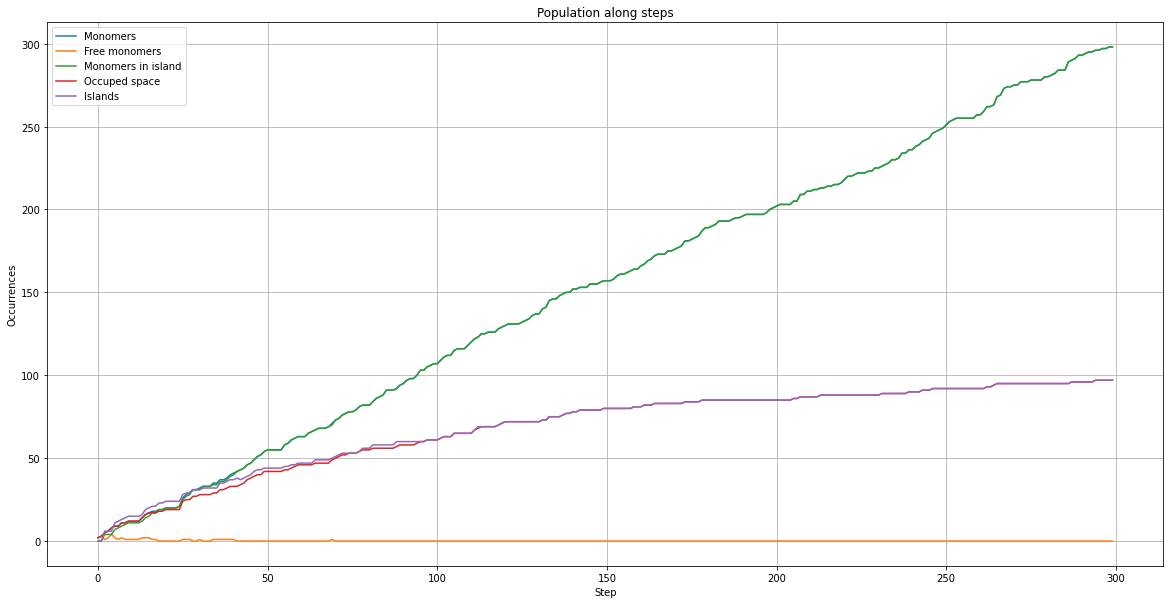

In [7]:
plt.figure(figsize=(20,10))
plt.plot(stepline, monomers, label="Monomers")
plt.plot(stepline, free_monomers, label="Free monomers")
plt.plot(stepline, stuck_monomers, label="Monomers in island")
plt.plot(stepline, occuped_space, label="Occuped space")
plt.plot(stepline, islands, label="Islands")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Occurrences")
plt.title("Population along steps")
plt.grid()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


300
Generating animation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 300/300 0:02:11eta 0:00:01


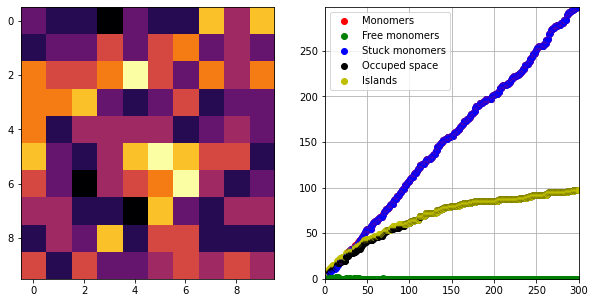

In [8]:
print(len(evolution))
animation.generate(evolution, monomers, free_monomers, stuck_monomers, islands, occuped_space, save_as = f"{path}/Evolution.gif", plot=False, verbose = False)